<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute predictions on a TF dataset using an stored .h5 model

In [1]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [2]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
# from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

Tensorflow version = 2.4.1
Executing eagerly = True


In [4]:
import xgboost as xgb
print('XGBoost version = {}'.format(xgb.__version__))

XGBoost version = 0.90


In [5]:
#%cd /content/drive/My\ Drive/Healthcare/Radioterapia/data/ciolaplata
#!unrar x /content/drive/My\ Drive/Healthcare/Radioterapia/Mapas\ CIO\ La\ Plata/Mapas\ Calculados/2019.rar
#!ls -l 2015/*dcm | wc -l

if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd -q '/content/fluence_maps'

    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

Cloning into 'fluence_maps'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 295 (delta 5), reused 3 (delta 0), pack-reused 280
Receiving objects: 100% (295/295), 2.03 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 1198654
-rw------- 1 root root 132221552 Jan 16 19:45 1610826316.h5
-rw------- 1 root root 156500040 Jan 16 20:13 1610828018.h5
-rw------- 1 root root 156500040 Jan 16 20:53 1610830410.h5
-rw------- 1 root root 132221552 Jan 16 21:10 1610831434.h5
-rw------- 1 root root 132221552 Jan 17 02:08 1610849307.h5
-rw------- 1 root root 156500040 Jan 17 18:09 1610906968.h5
-rw------- 1 root root 156500040 Jan 17 23:04 1610924689.h5
-rw------- 1 root root 204753488 Jan 31 15:54 1612108487.23456.h5


In [6]:
from util.dataset import _tfrecord_dataset_type_from_folder, _parse_jpeg_image_function
from util.preprocess import rescale_0_to_1

In [7]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_RANDOM_SEED=23456
ARG_TFDATASET_FOLDER=f'tfds.2019.localnorm.DS10%.{ARG_RANDOM_SEED}'
# ARG_MODEL_NAME = '1612063529' # VGG16 20 de enero 2021
ARG_MODEL_NAME = f'1612108487.{ARG_RANDOM_SEED}' # ene-31 ResNet18 buen(sobre) ajuste en training.
# ARG_MODEL_NAME = '1611181684' # ResNet 18 20 de enero 2021
PART_TRAIN = 'train'
PART_VALIDATION = 'validation'
PART_TEST = 'test'
PART_TO_USE = PART_VALIDATION
BATCH_SIZE = 32 # mae puede variar según batch size.
num_workers = 8
ARG_TRANSFORM_GAMMA=False
ARG_TRAIN_XGBOOST=False

In [8]:
def getMapDatasetForPartition(part):
    tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
    raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, part)
    print(raw_test)

    # Apply this function to each item in the dataset using the map method:
    IMG_SIZE = 256
    normalization_fn = rescale_0_to_1
    test = raw_test.map(lambda e: _parse_jpeg_image_function(e, IMG_SIZE, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA), num_parallel_calls=num_workers)
    
    gamma_values = test.map(lambda image, gamma, filename: gamma)
    gamma_values = np.array(list(gamma_values.as_numpy_iterator()))
    gamma_values[:20]
    
    return test

In [9]:
map_dataset = getMapDatasetForPartition(PART_TO_USE)
print(map_dataset)
print(map_dataset.batch(BATCH_SIZE))

<TFRecordDatasetV2 shapes: (), types: tf.string>
<ParallelMapDataset shapes: ((256, 256, 3), (), ()), types: (tf.float32, tf.float32, tf.string)>
<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


In [10]:
def getBatchesForPartition(test, part):
    test_batches = test.batch(BATCH_SIZE)
    print(test_batches)

    tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
    
    return tmp_test_batches

In [11]:
# load model
dir = os.path.join(ARG_DATASET_DIR, "models")
saved_model_dir = '{}/{}.h5'.format(dir, ARG_MODEL_NAME)
print(f'Loading model {saved_model_dir}...')
loaded_model = tf.keras.models.load_model(saved_model_dir)

Loading model /content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models/1612108487.23456.h5...


In [12]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 12,062,209
Non-trainable params: 2,915,648
_________________________________________________________________


In [13]:
tmp_test_batches = getBatchesForPartition(map_dataset, PART_TO_USE)
print(tmp_test_batches)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


In [14]:
def evaluatePartition(tmp_batches, part):
    # Evaluate dataset with the loaded model to calculate loss (mae) because
    # metric value could differ from the one reported during training.
    loss, mse = loaded_model.evaluate(tmp_batches, workers=num_workers, verbose=0)
    print('Loaded model, {} loss: {:5.4f}'.format(part, loss))
    print('Loaded model, {} mse: {:5.4f}\n'.format(part, mse))

In [15]:
# evaluatePartition(tmp_test_batches, PART_TO_USE)

In [16]:
def getPredictionsDataframe(test, part):
    tmp_batches = getBatchesForPartition(test, part)
    # Make predictions
    predictions = loaded_model.predict(tmp_batches)
    # from (1121,1) to (1121,); ie.: ndim = 2 to ndim = 1
    predictions = predictions.reshape(-1)
    predictions.shape

    tmp_test_dataset = test.map(lambda image, gamma, filename: (filename, gamma))
    print(tmp_test_dataset)

    lst = [(filename.numpy().decode('utf-8'), gamma.numpy()) for filename, gamma in tmp_test_dataset]
    lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

    # armar un pandas dataframe con el test set completo
    df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
    dir = os.path.join(ARG_DATASET_DIR, "predictions")
    predictions_file_path = '{}/predicted_gamma_{}.{}.csv'.format(dir, ARG_MODEL_NAME, part)
    df.to_csv(predictions_file_path, index=False)
    print(f'Predictions saved to {predictions_file_path}.\n')
    
    return df

In [17]:
df = getPredictionsDataframe(map_dataset, PART_TO_USE)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((), ()), types: (tf.string, tf.float32)>
Predictions saved to /content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/predictions/predicted_gamma_1612108487.23456.validation.csv.



In [18]:
def display_scatterplot(part, y, y_hat):
    print('Set size = %d' % len(y))

    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE on %s = %.3f' % (part, mae))

    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Corr. actual vs predicted = %.3f' % corr)

    r2score = r2_score(y, y_hat)
    print('R^2 = %.3f' % r2score)
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted (%s)' % part)
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    ax.plot([minimum+3, 100], [minimum, 97], ls="--", c=".4")
    ax.plot([minimum, 97], [minimum+3, 100], ls="--", c=".4")
    plt.show()

Set size = 243
MAE on validation = 1.217
Corr. actual vs predicted = 0.671
R^2 = 0.444


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


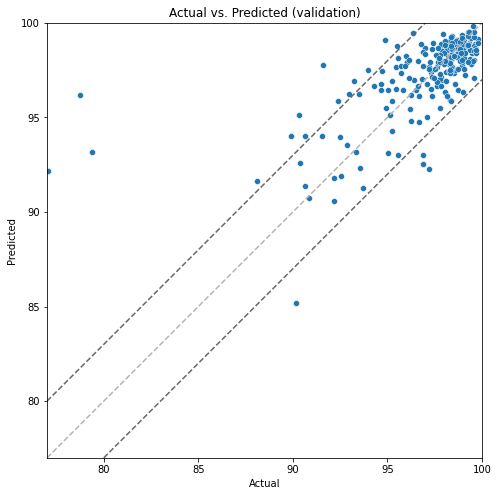

<Figure size 1080x1080 with 0 Axes>

In [19]:
y = df['actual gamma']
y_hat = df['predicted gamma']
display_scatterplot(PART_TO_USE, y, y_hat)

## Train an XGBoost model with extracted CNN features

In [20]:
# For VGG16 only
def extractFeatures(test, part):
    tmp_test_batches = getBatchesForPartition(test, part)
    print(tmp_test_batches)

    inputs=loaded_model.get_layer("vgg16").input
    outputs=loaded_model.get_layer("vgg16").output
    cnn_part=tf.keras.models.Model(inputs, outputs)
    predictions = cnn_part.predict(tmp_test_batches)

    predictions[0][:,:,3].mean()

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(predictions)
    extracted_features = feature_batch_average.numpy()

    from math import isclose
    a=predictions[0][:,:,3].mean()
    b=extracted_features[0][3]
    isclose(a, b, rel_tol=1e-6)

    return extracted_features

In [21]:
extracted_features = extractFeatures(map_dataset, PART_TRAIN)
extracted_features.shape

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


(243, 512)

In [22]:
df_features = pd.DataFrame(extracted_features)
df_result = pd.concat([df, df_features], axis=1)

In [23]:
part = PART_VALIDATION
map_dataset = getMapDatasetForPartition(part)
tmp_test_batches = getBatchesForPartition(map_dataset, part)
evaluatePartition(tmp_test_batches, part)
df_validation = getPredictionsDataframe(map_dataset, part)
y = df_validation['actual gamma']
y_hat = df_validation['predicted gamma']
display_scatterplot(PART_VALIDATION, y, y_hat)
extracted_features = extractFeatures(map_dataset, part)
df_validation_features = pd.DataFrame(extracted_features)
df_validation_result = pd.concat([df_validation, df_validation_features], axis=1)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


KeyboardInterrupt: ignored

In [ ]:
# training
df_result

In [ ]:
# validation
df_validation_result

In [ ]:
SEED = 12345

X_train = df_features
y_train = df['actual gamma']
X_valid = df_validation_features
y_valid = df_validation['actual gamma']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
print(f'Number of features = {len(dtrain.feature_names)}')

In [ ]:
def save_best_model(model_file):
    best_score = float('inf')
    
    def callback(env):
        nonlocal best_score
        if env.evaluation_result_list[-1][1] < best_score:
            env.model.save_model(model_file)
            best_score = env.evaluation_result_list[-1][1]
            
    return callback;

In [ ]:
# specify parameters via map, definition are same as c++ version: https://xgboost.readthedocs.io/en/latest/parameter.html or
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
param = {'max_depth': 2
         , 'eta': 0.1
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['rmse', 'mae']
         , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'seed': SEED
         , 'min_child_weight': 5
        }

MODEL_FILE = 'best-xgboost.model'
saved_model_dir = '{}/{}'.format(dir, MODEL_FILE)

# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
results = {}
num_boost_round = 150
bst = xgb.train(param, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=10, evals_result=results, callbacks=[save_best_model(saved_model_dir)])

In [ ]:
epochs = len(results['train']['mae'])
x_axis = range(0, epochs)
# plot MAE
fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['mae'], label='Training')
ax.plot(x_axis, results['valid']['mae'], label='Validation')
plt.axvline(bst.best_iteration, linestyle='--', color='k', label='best iteration')
ax.legend()
plt.ylabel('MAE')
plt.xlabel('iteration')
plt.title('XGBoost MAE')
ymin=0; ymax=10
plt.ylim(ymin, ymax)
plt.show()

In [ ]:
print('best iteration: %i, best MAE on validation: %.3f' % (bst.best_iteration, bst.best_score))

In [ ]:
bst = xgb.Booster()  # init model
bst.load_model(saved_model_dir)  # load data

In [ ]:
# This is prediction
y_hat = bst.predict(dvalid)
display_scatterplot(PART_VALIDATION, y_valid, y_hat)

In [ ]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')